In [12]:
import pandas as pd
import yfinance
from datetime import date,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import joblib
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [13]:
StartDate = (date.today()-timedelta(days=7)).strftime('%Y-%m-%d')
EndDate= (date.today()).strftime('%Y-%m-%d')
StartDate,EndDate

('2024-01-22', '2024-01-29')

In [14]:
ticker = "^NSEI"
df=yfinance.download(tickers=ticker,start=StartDate,end=EndDate,interval='1m')
print(df.shape)
df.head()

[*********************100%%**********************]  1 of 1 completed

(1124, 6)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-01-23 09:15:00+05:30,21716.699219,21738.849609,21711.449219,21736.550781,21736.550781,0
2024-01-23 09:16:00+05:30,21737.400391,21749.250000,21736.300781,21736.349609,21736.349609,0
2024-01-23 09:17:00+05:30,21736.400391,21745.349609,21735.150391,21742.900391,21742.900391,0
2024-01-23 09:18:00+05:30,21742.750000,21742.750000,21733.550781,21734.949219,21734.949219,0
2024-01-23 09:19:00+05:30,21735.400391,21736.750000,21723.000000,21727.150391,21727.150391,0


In [15]:
plt.figure(figsize=(15,7))
line=px.line(data_frame=df,x=df.index,y=df.columns,title="NIFTY-50 Stock Prices")
line.show()

<Figure size 1500x700 with 0 Axes>

In [18]:
y = df[['Open','High','Low','Close','Adj Close']]
for i in range(len(y.columns)):
    adfTest = adfuller(y[y.columns[i]],autolag='AIC')
    if adfTest[1]<0.05:
        print(f'{adfTest[1]} is stationarity {y.columns[i]}')
    else:
        print(f'{adfTest[1]} is not stationarity {y.columns[i]}')

0.018942299531621676 is stationarity Open
0.01837568745302142 is stationarity High
0.01812416614985193 is stationarity Low
0.02091487550706805 is stationarity Close
0.02091487550706805 is stationarity Adj Close


In [23]:
train_size = int(0.8 * len(y))
train, test = y[:train_size], y[train_size:]
y.dropna(inplace=True)
exogtrain = train['Open']
exogtrain2=train['High']
exogtrain3=train['Low']
exogtest = test['Open']
exogtest2=test['High']
exogtest3=test['Low']
exogtrain.shape,exogtest.shape,train.shape,test.shape

/tmp/ipykernel_28228/3190282135.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((899,), (225,), (899, 5), (225, 5))

In [28]:
exogdftrain = pd.concat([exogtrain, exogtrain2, exogtrain3], axis=1)
exogdftest = pd.concat([exogtest, exogtest2, exogtest3], axis=1)
train.index = pd.date_range(start=train.index[0], periods=len(train), freq='H')
exogdftrain.index = train.index
var_model = VAR(endog=train,dates=train.index,exog=exogdftrain)
var_fit = var_model.fit(trend='c'
                        ,verbose=True,)
predictions3=var_fit.forecast(y=train.values, steps=len(test),exog_future=exogdftest.values)
predictions3

array([[21351.94921875, 21357.59960937, 21341.15039062, 21348.1235282 ,
        21348.1235282 ],
       [21357.25      , 21358.30078125, 21340.05078125, 21345.05522334,
        21345.05522334],
       [21340.09960938, 21342.15039062, 21328.94921875, 21332.4958307 ,
        21332.4958307 ],
       ...,
       [21384.75      , 21401.75      , 21381.30078125, 21396.30444812,
        21396.30444812],
       [21392.69921875, 21396.25      , 21384.25      , 21389.1475266 ,
        21389.1475266 ],
       [21391.75      , 21394.40039062, 21367.40039062, 21375.24697806,
        21375.24697806]])

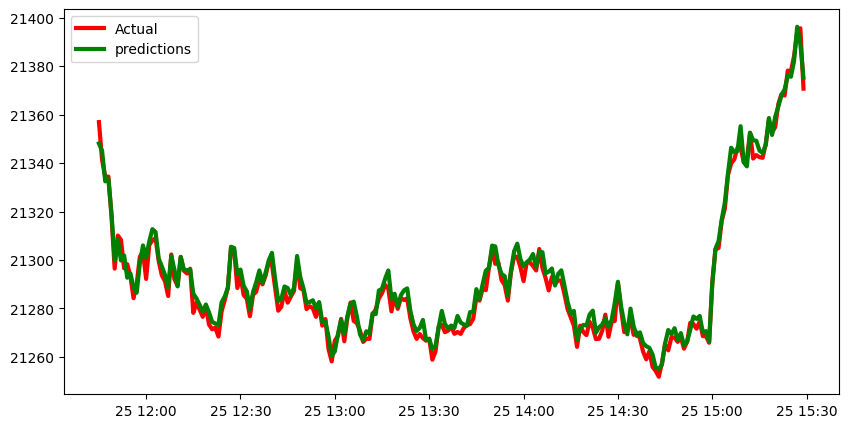

In [29]:
var_dataset = pd.DataFrame(data=predictions3,index=test.index,columns=train.columns)
plt.figure(figsize=(10,5))
plt.plot(test['Close'],label="Actual",color="red",linestyle="-",linewidth="3")
plt.plot(var_dataset['Close'],label="predictions",color="green",linestyle="-",linewidth="3")
plt.legend()

In [30]:
model=joblib.dump(var_fit,'Var.joblib')

In [31]:
mean_squared_error(test,predictions3)

4.9190217747898